In [1]:
!pip install pybullet seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pybullet: filename=pybullet-3.2.7-cp312-cp312-linux_x86_64.whl size=99873468 sha256=c082a3f555ab0003da791bfdaa8cd329ff1d2a393cea1c8536a20f2ec1c43d65
  Stored in directory: /root/.cache/pip/wheels/72/95/1d/b336e5ee612ae9a019bfff4dc0bedd100ee6f0570db205fdf8
Successfully built pybullet


In [2]:
import pybullet as p
import pybullet_data
import numpy as np
import pandas as pd
import random
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
def run_simulation(mass, friction, force, duration, gravity):
    physicsClient = p.connect(p.DIRECT)
    p.setAdditionalSearchPath(pybullet_data.getDataPath())
    p.resetSimulation()

    p.setGravity(0, 0, -gravity)

    plane = p.loadURDF("plane.urdf")

    box_collision = p.createCollisionShape(
        p.GEOM_BOX, halfExtents=[0.5, 0.5, 0.5]
    )

    box_visual = p.createVisualShape(
        p.GEOM_BOX, halfExtents=[0.5, 0.5, 0.5]
    )

    box = p.createMultiBody(
        baseMass=mass,
        baseCollisionShapeIndex=box_collision,
        baseVisualShapeIndex=box_visual,
        basePosition=[0, 0, 0.5]
    )

    p.changeDynamics(box, -1, lateralFriction=friction)

    start_pos, _ = p.getBasePositionAndOrientation(box)

    steps = int(duration * 240)

    for _ in range(steps):
        p.applyExternalForce(
            box,
            -1,
            [force, 0, 0],
            [0, 0, 0],
            p.WORLD_FRAME
        )
        p.stepSimulation()

    end_pos, _ = p.getBasePositionAndOrientation(box)
    p.disconnect()

    displacement = end_pos[0] - start_pos[0]
    return displacement


In [4]:
PARAM_RANGES = {
    "mass": (0.5, 10),
    "friction": (0.1, 1.0),
    "force": (1, 50),
    "time": (1, 10),
    "gravity": (8, 12)
}


In [5]:
data = []

NUM_SAMPLES = 1000

for i in range(NUM_SAMPLES):
    mass = random.uniform(*PARAM_RANGES["mass"])
    friction = random.uniform(*PARAM_RANGES["friction"])
    force = random.uniform(*PARAM_RANGES["force"])
    time_duration = random.uniform(*PARAM_RANGES["time"])
    gravity = random.uniform(*PARAM_RANGES["gravity"])

    displacement = run_simulation(
        mass, friction, force, time_duration, gravity
    )

    data.append([
        mass, friction, force, time_duration, gravity, displacement
    ])

df = pd.DataFrame(
    data,
    columns=["mass", "friction", "force", "time", "gravity", "displacement"]
)

df.head()


,mass,friction,force,time,gravity,displacement
0,2.803442,0.733188,23.442041,3.634321,10.629900,3.423697
1,6.067292,0.294719,21.519642,4.869382,9.063628,8.711252
2,1.491761,0.153091,13.553203,6.154454,10.182572,65.034566
3,8.562978,0.296756,36.709740,1.684876,9.596982,1.948490
4,5.208042,0.567517,6.763520,8.165889,8.967699,-0.000103


In [6]:
df.to_csv("simulation_data.csv", index=False)


In [7]:
X = df.drop("displacement", axis=1)
y = df["displacement"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [8]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor()
}


In [9]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append([name, mae, rmse, r2])

results_df = pd.DataFrame(
    results, columns=["Model", "MAE", "RMSE", "R2 Score"]
)

results_df.sort_values(by="RMSE")


,Model,MAE,RMSE,R2 Score
4,Random Forest,5.634084,12.116794,0.910226
5,Gradient Boosting,7.873052,12.447837,0.905254
3,Decision Tree,8.132613,17.615026,0.810268
7,KNN,11.846531,19.762272,0.761193
0,Linear Regression,19.525354,27.949489,0.522337
1,Ridge Regression,19.532128,27.962617,0.521889
2,Lasso Regression,19.783925,28.602043,0.499773
6,SVR,18.230436,38.981782,0.070827


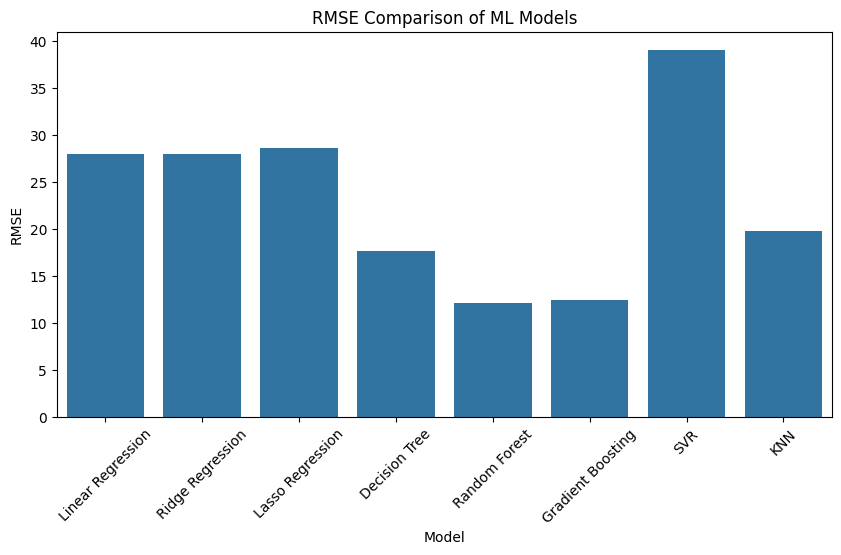

In [10]:
plt.figure(figsize=(10,5))
sns.barplot(x="Model", y="RMSE", data=results_df)
plt.xticks(rotation=45)
plt.title("RMSE Comparison of ML Models")
plt.show()


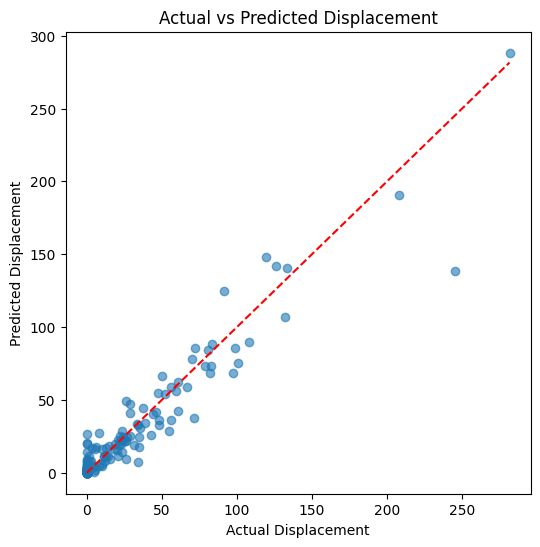

In [11]:
best_model = RandomForestRegressor(n_estimators=100)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Displacement")
plt.ylabel("Predicted Displacement")
plt.title("Actual vs Predicted Displacement")
plt.show()


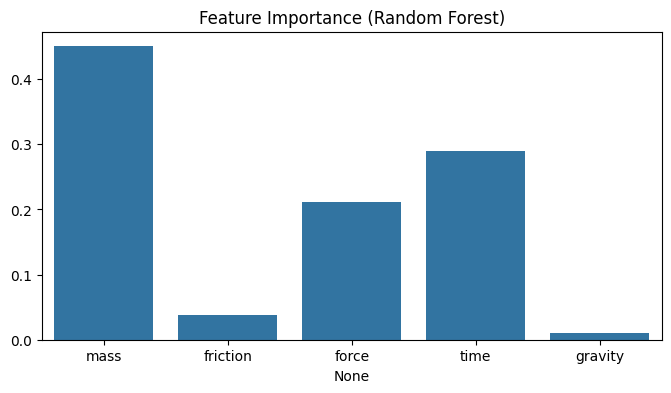

In [12]:
importances = best_model.feature_importances_

plt.figure(figsize=(8,4))
sns.barplot(x=X.columns, y=importances)
plt.title("Feature Importance (Random Forest)")
plt.show()
